# Comparing NN-receiver performance against ZF/LS receiver performance on testset

In [29]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models_local import *
from OFDM_SDR_Functions_torch import *

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Display the selected device
print(device)

# Test tensor creation on the selected device
if device.type != "cpu":
    x = torch.ones(1, device=device)
    print(x)

device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps


cuda:0
tensor([1.], device='cuda:0')


## Load the testset, model and weights

In [30]:

model = RXModel_2(Qm).to(device)

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False).to(device) # TTI mask
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power).to(device) # pilot symbols

mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

# load the testset
test_set = torch.load('data/ofdm_testset.pth')
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Load the model architecture and weights
checkpoint_path = 'data/rx_model_96.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Evaluate the model on the test set
test_losses_NN = []
test_BERs_NN = []
test_BERs_ZFLS = []


## Run the testset and measure BER with both receivers

In [31]:
# remove DC and FFT offsets from TTI mask_RE and add third dimension size of Qm, and expand TTI mask values into the third dimension
TTI_mask_RE_small = TTI_mask_RE[:, FFT_offset:-FFT_offset]
middle_index = TTI_mask_RE_small.size(1) // 2
TTI_mask_RE_small = torch.cat((TTI_mask_RE_small[:, :middle_index], TTI_mask_RE_small[:, middle_index + 1:]), dim=1)

TTI_mask_RE_3d = TTI_mask_RE_small.unsqueeze(-1).expand(S, F-1, Qm)
wrongs=[]
wrongs_ls=[]
with torch.no_grad():
    for test_pdsch_iq, test_labels in test_loader:
        
        # NN receiver ###################################################
        test_outputs = model((test_pdsch_iq.to(device)))
        binary_predictions = test_outputs.squeeze()[TTI_mask_RE_3d==1]
        binary_predictions = torch.round(binary_predictions)
        test_labels = test_labels.squeeze()[TTI_mask_RE_3d==1]

        # load a batch of data to the device
        test_pdsch_iq, test_labels = test_pdsch_iq.squeeze().to(device), test_labels.squeeze().to(device)

        # Calculate Bit Error Rate (BER) for the NN-receiver
        error_count = torch.sum(binary_predictions != test_labels).float()  # Count of unequal bits

        new_wrongs = (binary_predictions.flatten() != test_labels.flatten()).float().tolist()
        wrongs.append(new_wrongs)

        
        error_rate = error_count / len(test_labels.flatten())  # Error rate calculation
        BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        test_BERs_NN.append(BER_NN.item())

        # ZF-LS receiver ####################################################

        # add DC and FFT offsets, as channel estimation expects those
        test_pdsch_iq_w = torch.cat((torch.zeros(S, FFT_offset, dtype=test_pdsch_iq.dtype, device=device), test_pdsch_iq, torch.zeros(S, FFT_offset, dtype=test_pdsch_iq.dtype, device=device)), dim=1) # add FFT offset
        middle_index = test_pdsch_iq_w.size(1) // 2+1
        test_pdsch_iq_w = torch.cat((test_pdsch_iq_w[:, :middle_index], torch.zeros(S, 1, device=device), test_pdsch_iq_w[:, middle_index:]), dim=1) # add DC
        
        test_pdsch_iq_w_t = test_pdsch_iq_w
        
        # calculate channel estimate
        H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, test_pdsch_iq_w, plotEst=False)

        # remove FFT offsets
        test_pdsch_iq_w = remove_fft_Offests(test_pdsch_iq_w, F, FFT_offset)
        
        # equalize the received signal
        equalized_H_estim = equalize_ZF(test_pdsch_iq_w, H_estim, F, S)

        # get the payload symbols 
        QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=False)

        # demap the symbols
        PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)

        # convert to bits
        bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8)

        # Calculate Bit Error Rate (BER) for the ZF-LS receiver
        test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)
        
        new_wrongs_ls = (bits_est != test_labels).float().tolist()
        wrongs_ls.append(new_wrongs_ls)
        
        error_count = torch.sum(bits_est != test_labels).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER_ZFLS = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        test_BERs_ZFLS.append(BER_ZFLS.item())

/tmp/ipykernel_762479/1887353876.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8)
/tmp/ipykernel_762479/1887353876.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)


## observe if there are time domain problems, either in the NN, or in the LS receiver

Text(0, 0.5, 'cumulative errors')

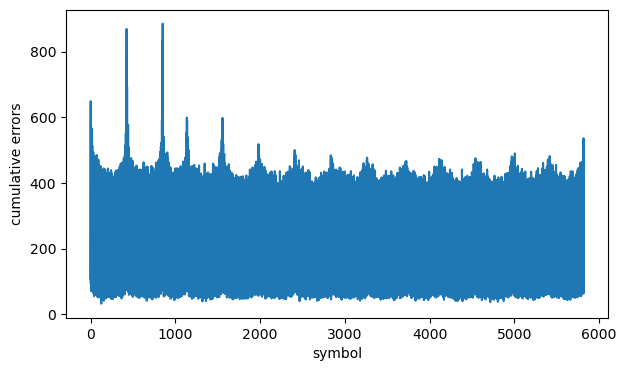

In [32]:
# NN receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs, axis=0))
plt.xlabel('symbol')
plt.ylabel('cumulative errors')

Text(0, 0.5, 'cumulative errors')

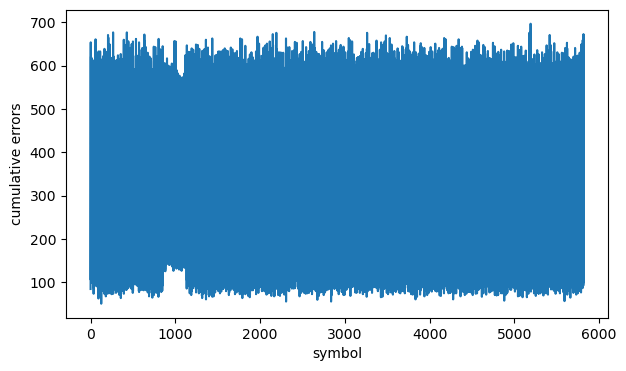

In [33]:
#LZ/ZF receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs_ls, axis=0))
plt.xlabel('symbol')
plt.ylabel('cumulative errors')

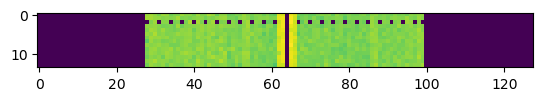

In [34]:
# Create a zero tensor for the overall F subcarriers * S symbols
TTI_t = np.zeros(TTI_mask_RE.shape)
wrongs = np.array(wrongs_ls).astype(int)
wrongs=wrongs.sum(axis=0)
wrongs=wrongs.reshape([970,6]).sum(axis=1)

# Allocate the payload and pilot
TTI_t[TTI_mask_RE==1] = wrongs
plt.imshow(TTI_t)

## Calculate the mean BER, illustrate BER distribution

In [35]:
# Calculate average test loss and BER
average_test_BER_NN = sum(test_BERs_NN) / len(test_BERs_NN)
average_test_BER_ZFLS = sum(test_BERs_ZFLS) / len(test_BERs_ZFLS)

# Print or log average test loss and BER for both the NN and ZF-LS receiver
print('Average test BER NN: {:.4f}'.format(average_test_BER_NN))
print('Average test BER ZF-LS: {:.4f}'.format(average_test_BER_ZFLS))

Average test BER NN: 0.0444
Average test BER ZF-LS: 0.0670


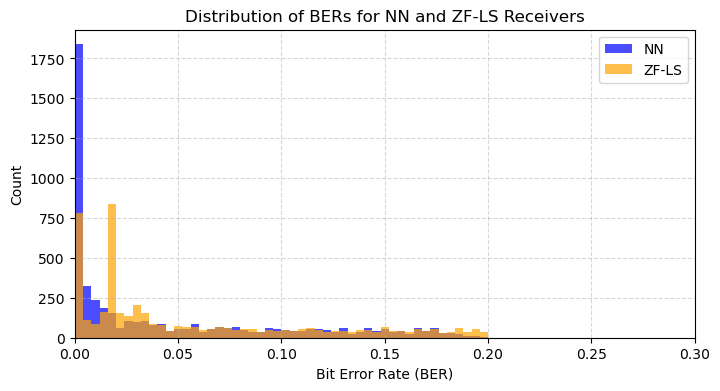

In [37]:
bins = np.linspace(0, 0.2, 51)

# Plotting with logarithmic scale for y-axis
plt.figure(figsize=(8, 4))
plt.hist(test_BERs_NN, bins=bins, alpha=0.7, color='blue', label='NN')
plt.hist(test_BERs_ZFLS, bins=bins, alpha=0.7, color='orange', label='ZF-LS')
plt.xlabel('Bit Error Rate (BER)')
plt.ylabel('Count')
plt.title('Distribution of BERs for NN and ZF-LS Receivers')
plt.legend()
plt.xlim(0, 0.3)
#plt.yscale('log')  # Setting y-axis to logarithmic scale
plt.grid(True, linestyle='--', alpha=0.5)
if save_plots:
    plt.savefig('pics/BER_distribution_testset_log_scale.png', bbox_inches='tight')
plt.show()